# <center>COMPUTER VISION - VGG16 MODEL</center>
***
## <font color = blue>I. DATA PREPARATION</font>
> A. LIBRARIES<br>
> B. CONSTANTS<br>
> C. COLLECTING DATA AND LOADING A SAMPLE<br>
> D. SPLIT BETWEEN TRAINING SET AND TEST SET<br>
> E. PREPARATION OF DATA WITH PREPROCESSING<br>

## <font color = blue>II. CALL BACKS</font>
> A. AUTOMATIC REDUCTION OF THE LEARNING RATE<br>
> B. EARLY STOPPING<br>

## <font color = blue>III. TRANSFER LEARNING</font>
> A. LOADING OF VGG16 PRE-TRAINED MODEL<br>
> B. MODEL CREATION WITH LAST LAYERS<br>
> C. COMPILING AND TRAINING<br>
> D. TRAINING HISTORY<br>
> E. CONFUSION MATRIX<br>
> F. CLASSIFICATION REPORT<br>

## <font color = blue>IV. FINE TUNING</font>
> A. UNFREEZING WEIGHTS OF 4 LAST LAYERS OF VGG16<br>
> B. COMPILING AND TRAINING<br>
> C. TRAINING HISTORY<br>
> D. CONFUSION MATRIX<br>
> E. CLASSIFICATION REPORT<br>

## <font color = blue>V. WRONG PREDICTIONS</font>
***
##### Additional information before to get started :
* Recommended resolution for the pre-trained VGG16 model : (224, 224, 3).
    * https://keras.io/api/applications/vgg/
* Note: each Keras Application expects a specific kind of input preprocessing. For VGG16, vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

##### Laptop specification :
* OS: Windows 11
* Processor: AMD Ryzen 7 5800HS with Radeon Graphics 3.20 GHz
* Installed RAM: 16,0 GB
* GPU: NVIDIA GetForce RTX3080 8GB
***

## <font color = blue>I. DATA PREPARATION</font>
> A. LIBRARIES

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from time import time

from helpers import load_image, show_wrong_predictions, confusion_matrix, global_classification_report

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

> B. CONSTANTS

In [2]:
BATCH_SIZE       = 16                # Bacth size for dataset
TARGET_SIZE      = (224, 224)        # Resolution of images before training
INPUT_SHAPE      = (224, 224, 3)     # Resolution of images with channels before training
IMAGES_DIRECTORY = '../data/final/'  # Directory where are located images

SAVED_WEIGHTS    = './model/model_VGG16.h5'  # File name where are saved the final weights of the model

> C. COLLECTING DATA AND LOADING A SAMPLE

In [3]:
df = pd.read_csv('../data/data.csv')
df.head()

Unnamed: 0.1  Unnamed: 0         filename  \
0             0           0  img_0000000.jpg   
1             1           1  img_0000001.jpg   
2             2           2  img_0000002.jpg   
3             3           3  img_0000003.jpg   
4             4           4  img_0000004.jpg   

                                                 url  \
0  https://templates.invoicehome.com/modele-factu...   
1  https://templates.invoicehome.com/modele-factu...   
2  https://www.coover.fr/wp-content/uploads/2021/...   
3  https://templates.invoicehome.com/modele-factu...   
4  https://files.intum.com/v/vosfactures/files/31...   

                                         description     type  \
0  100 modèles gratuits de factures | Téléchargem...  facture   
1  100 modèles gratuits de factures | Téléchargem...  facture   
2  Facture proforma : modèle à télécharger gratui...  facture   
3  100 modèles gratuits de factures | Téléchargem...  facture   
4  Base de Connaissances - Vos Factures - Créer u...  facture   

                  filepath  scraped     old_filename  \
0  ./final/img_0000000.jpg        1  img_0000000.jpg   
1  ./final/img_0000001.jpg        1  img_0000001.jpg   
2  ./final/img_0000002.jpg        1  img_0000002.jpg   
3  ./final/img_0000003.jpg        1  img_0000003.jpg   
4  ./final/img_0000004.jpg        1  img_0000004.jpg   

                old_filepath  ...  \
0  ./facture/img_0000000.jpg  ...   
1  ./facture/img_0000001.jpg  ...   
2  ./facture/img_0000002.jpg  ...   
3  ./facture/img_0000003.jpg  ...   
4  ./facture/img_0000004.jpg  ...   

                                            text_ocr  words_count  \
0   FACTURE LOGO Joanna Binet 48 Coubertin 31400 ...           98   
1   Joanna Binet 48 Coubertin 31400 Paris FACTURE...           97   
2   FACTURE Mon entreprise : Nom de la société Ad...           45   
3   Joanna Binet 48 Coubertin 31400 Paris FACTURE...           99   
4   Payer en ligne > FACTURE No SFIDELI F/05.2020...          157   

                                             text_en  \
0  Invoice Logo Joanna Binet Coubertin Paris Invo...   
1  Joanna Binet Coubertin Paris Invoice Invoice i...   
2  Invoice My company : Company name Mail address...   
3  Joanna Binet Coubertin Paris Bill To Cinderell...   
4  Pay online Invoice No Sfideli F/ Creation date...   

                                             text_fr  \
0   Facture Logo Joanna Binet  Coubertin  Paris F...   
1   Joanna Binet  Coubertin  Paris Facture Factur...   
2   Facture Mon entreprise : Nom de la société Ad...   
3   Joanna Binet  Coubertin  Paris Facture À Cend...   
4   Payer en ligne  Facture No Sfideli F/ Date de...   

                                        text_fr_norm  \
0  facture logo joanna binet coubertin paris fact...   
1  joanna binet coubertin paris facture facturé c...   
2  facture entreprise société adresse postale adr...   
3  joanna binet coubertin paris facture cendrillo...   
4  payer ligne facture sfideli date création date...   

                                        text_en_norm  target_en target_fr  \
0  invoice logo joanna binet coubertin paris invo...    invoice   facture   
1  joanna binet coubertin paris invoice invoice c...    invoice   facture   
2  invoice company company name mail address tele...    invoice   facture   
3  joanna binet coubertin paris bill cinderella a...    invoice   facture   
4  online invoice sfideli creation date validity ...    invoice   facture   

    target target_min  
0  invoice    invoice  
1  invoice    invoice  
2  invoice    invoice  
3  invoice    invoice  
4  invoice    invoice  

[5 rows x 27 columns]

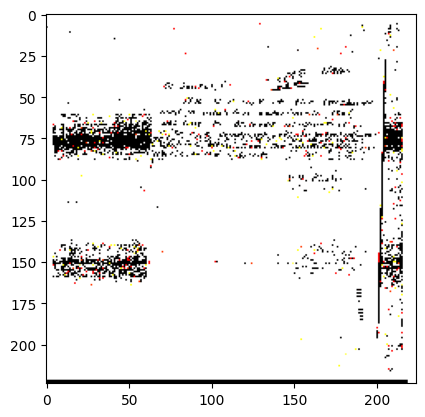

In [4]:
# Display a document randomly
num_alea = np.random.randint(len(df))

plt.imshow(load_image(directory = IMAGES_DIRECTORY,
                      filename = df.filename[num_alea],
                      preprocess = preprocess_input));

#Comments:
#- The method load_image is resizing images to (224, 224) by default,
#- VGG16 preprocessing is converting images from RGB to BGR.

> D. SPLIT BETWEEN TRAINING SET AND TEST SET

In [5]:
X_train_path, X_test_path, y_train, y_test = train_test_split(df.filename, df.target_min,
                                                              test_size = 0.2, random_state = 1234)

data_train ={'filename': X_train_path, 'type': y_train.astype('category')}
df_train = pd.DataFrame(data_train)

data_test ={'filename': X_test_path, 'type': y_test.astype('category')}
df_test = pd.DataFrame(data_test)

> E. PREPARATION OF DATA WITH PREPROCESSING

In [6]:
# Images generator for training set
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input) # data preprocessing for VGG16


# Generator for test set (we don't increase the test set)
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train,          # Dataframe
                                                           directory = IMAGES_DIRECTORY,  # Directory with pics
                                                           class_mode = 'categorical',    # Multiple classes
                                                           target_size = TARGET_SIZE,     # Resizing
                                                           x_col = 'filename',            # Column with filenames
                                                           y_col = 'type',                # Column with classes
                                                           batch_size = BATCH_SIZE)       # Batch size

test_generator = test_data_generator.flow_from_dataframe(dataframe = df_test,             # Dataframe
                                                         directory = IMAGES_DIRECTORY,    # Directory with pics
                                                         class_mode = 'categorical',      # Multiple classes
                                                         target_size = TARGET_SIZE,       # Resizing
                                                         x_col = 'filename',              # Column with filenames
                                                         y_col = 'type',                  # Column with classes
                                                         batch_size = BATCH_SIZE)         # Batch size

Found 1046 validated image filenames belonging to 14 classes.
Found 262 validated image filenames belonging to 14 classes.


## <font color = blue>II. CALL BACKS</font>
> A. AUTOMATIC REDUCTION OF THE LEARNING RATE

In [7]:
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',                # Metric to control
                                         patience = 3,                        # Number of epochs to wait before decreasing the learning rate
                                         factor = 0.1,
                                         verbose = 2,                         # Number of informations displayed during training
                                         mode = 'min')                        # Indicate the metric decrease

> B. EARLY STOPPING

In [8]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',          # Metric to control
                                         patience = 9,                  # Number of epochs to wait before stopping the training
                                         mode = 'min',                  # Indicate the metric decrease
                                         restore_best_weights = True)   # To restore the weights of the best epoch

## <font color = blue>III. TRANSFER LEARNING</font>
> A. LOADING OF VGG16 PRE-TRAINED MODEL

In [9]:
# Loading
vgg16 = VGG16(include_top = False, input_shape = INPUT_SHAPE)

# Freezing weigths
for layer in vgg16.layers:
    layer.trainable = False

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

> B. MODEL CREATION WITH LAST LAYERS

In [10]:
model = Sequential()
model.add(vgg16)
model.add(GlobalAveragePooling2D()) 
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 14, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

> C. COMPILING AND TRAINING

In [11]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),              # loss function
              optimizer = tf.keras.optimizers.Adam(),                        # optimizer algorithm
              metrics = ['accuracy'])                                        # metric

In [12]:
# Initialization of a timer
t0 = time()

history = model.fit(x = train_generator,                                     # Training data
                    validation_data = test_generator,                        # Validation data
                    epochs = 50,                                             # Number of epoch
                    steps_per_epoch = (len(X_train_path)) // BATCH_SIZE,     # Number of steps per Epoch
                    validation_steps = (len(X_test_path)) // BATCH_SIZE,     # Number of iterations during the test  
                    callbacks = [lr_plateau, early_stopping],                # Callbacks
                    workers = -1)                                            # Using all processors

# Calulation of training time
t1 = time() - t0
print("Training time in {} minutes".format(t1 // 60))

Epoch 1/50


C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 [==============================] - 23s 292ms/step - loss: 2.7335 - accuracy: 0.4272 - val_loss: 1.5633 - val_accuracy: 0.4805 - lr: 0.0010
Epoch 2/50
65/65 [==============================] - 17s 269ms/step - loss: 1.0572 - accuracy: 0.6806 - val_loss: 1.0844 - val_accuracy: 0.6055 - lr: 0.0010
Epoch 3/50
65/65 [==============================] - 18s 270ms/step - loss: 0.8123 - accuracy: 0.7427 - val_loss: 1.1457 - val_accuracy: 0.6055 - lr: 0.0010
Epoch 4/50
65/65 [==============================] - 17s 268ms/step - loss: 0.7005 - accuracy: 0.7670 - val_loss: 1.1884 - val_accuracy: 0.6523 - lr: 0.0010
Epoch 5/50
65/65 [==============================] - 17s 269ms/step - loss: 0.6097 - accuracy: 0.7913 - val_loss: 1.0581 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 6/50
65/65 [==============================] - 17s 269ms/step - loss: 0.5082 - accuracy: 0.8301 - val_loss: 1.2051 - val_accuracy: 0.6758 - lr: 0.0010
Epoch 7/50
65/65 [==============================] - 17s 269ms/step - loss: 

> D. TRAINING HISTORY

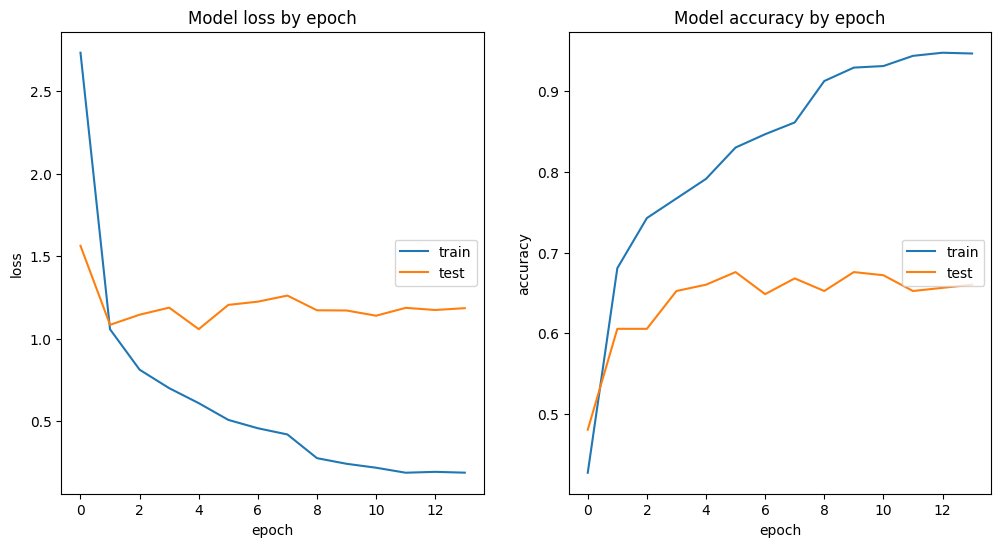

In [13]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

> E. CONFUSION MATRIX

In [14]:
# Probability predictions
X_test = [load_image(directory = IMAGES_DIRECTORY, filename = x, preprocess = preprocess_input) for x in X_test_path]
y_prob = [model.predict(np.array([x], dtype = np.float32))[0] for x in X_test]

# Class predictions
y_pred = tf.argmax(y_prob, axis = -1).numpy()

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


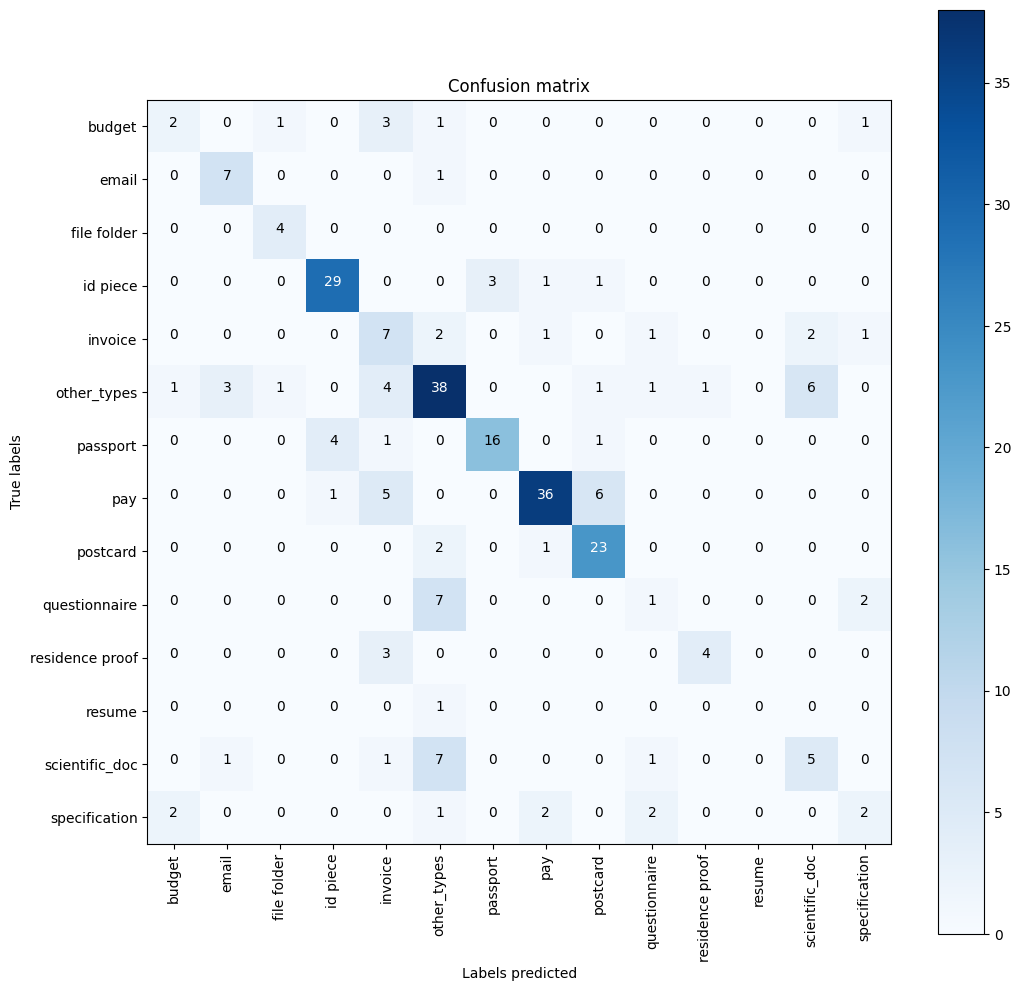

In [15]:
# Dictionaries for target
dico_type = test_generator.class_indices
dico_type_inv = {v: k for k, v in dico_type.items()}

# Class predictions with type (passport, resume, etc...)
y_pred_type = pd.DataFrame(y_pred, index = y_test.index).replace(dico_type_inv)

confusion_matrix(y_test, y_pred_type)

> F. CLASSIFICATION REPORT

In [16]:
print( classification_report(y_test, y_pred_type) )

                 precision    recall  f1-score   support

         budget       0.40      0.25      0.31         8
          email       0.64      0.88      0.74         8
    file folder       0.67      1.00      0.80         4
       id piece       0.85      0.85      0.85        34
        invoice       0.29      0.50      0.37        14
    other_types       0.63      0.68      0.66        56
       passport       0.84      0.73      0.78        22
            pay       0.88      0.75      0.81        48
       postcard       0.72      0.88      0.79        26
  questionnaire       0.17      0.10      0.12        10
residence proof       0.80      0.57      0.67         7
         resume       0.00      0.00      0.00         1
 scientific_doc       0.38      0.33      0.36        15
  specification       0.33      0.22      0.27         9

       accuracy                           0.66       262
      macro avg       0.54      0.55      0.54       262
   weighted avg       0.67   

C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## <font color = blue>IV. FINE TUNING</font>
> A. UNFREEZING WEIGHTS OF 4 LAST LAYERS OF VGG16

In [17]:
for layer in vgg16.layers[-4:]:
    layer.trainable = True

> B. COMPILING AND TRAINING

In [18]:
last_learning_rate = model.optimizer.learning_rate.numpy()              # collect last learning rate from previous training

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),                            # loss function
              optimizer = tf.keras.optimizers.Adam(learning_rate = last_learning_rate),    # optimizer algorithm
              metrics = ['accuracy'])                                                      # metric

In [19]:
# Initialization of a timer
t0 = time()

history = model.fit(x = train_generator,                                     # Training data
                    validation_data = test_generator,                        # Validation data
                    epochs = 50,                                             # Number of epoch
                    steps_per_epoch = (len(X_train_path)) // BATCH_SIZE,     # Number of steps per Epoch
                    validation_steps = (len(X_test_path)) // BATCH_SIZE,     # Number of iterations during the test  
                    callbacks = [lr_plateau, early_stopping],                # Callbacks
                    workers = -1)                                            # Using all processors

# Calulation of training time
t1 = time() - t0
print("Training time in {} minutes".format(t1 // 60))

Epoch 1/50


C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 [==============================] - 18s 277ms/step - loss: 0.4741 - accuracy: 0.8388 - val_loss: 1.0475 - val_accuracy: 0.6758 - lr: 1.0000e-06
Epoch 2/50
65/65 [==============================] - 18s 272ms/step - loss: 0.4472 - accuracy: 0.8417 - val_loss: 1.0443 - val_accuracy: 0.6680 - lr: 1.0000e-06
Epoch 3/50
65/65 [==============================] - 18s 270ms/step - loss: 0.4232 - accuracy: 0.8602 - val_loss: 1.0554 - val_accuracy: 0.6914 - lr: 1.0000e-06
Epoch 4/50
65/65 [==============================] - 18s 274ms/step - loss: 0.3910 - accuracy: 0.8699 - val_loss: 1.0516 - val_accuracy: 0.6992 - lr: 1.0000e-06
Epoch 5/50
65/65 [==============================] - ETA: 0s - loss: 0.3885 - accuracy: 0.8757
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
65/65 [==============================] - 18s 271ms/step - loss: 0.3885 - accuracy: 0.8757 - val_loss: 1.0490 - val_accuracy: 0.6992 - lr: 1.0000e-06
Epoch 6/50
65/65 [==============================] -

In [20]:
####### SAVING WEIGHTS #######
model.save_weights(SAVED_WEIGHTS)

> C. TRAINING HISTORY

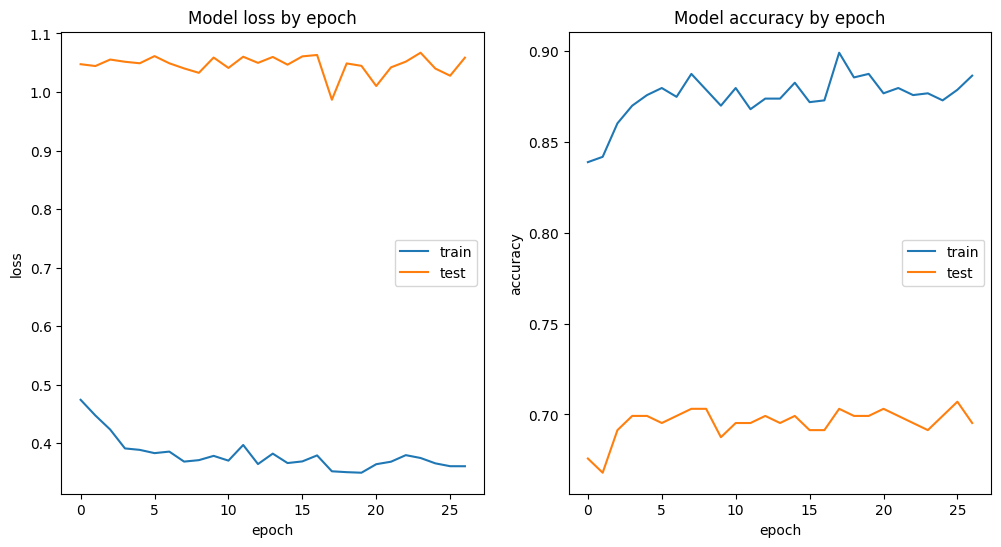

In [21]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

> D. CONFUSION MATRIX

In [22]:
# Probability predictions
X_test = [load_image(directory = IMAGES_DIRECTORY, filename = x, preprocess = preprocess_input) for x in X_test_path]
y_prob = [model.predict(np.array([x], dtype = np.float32))[0] for x in X_test]

# Class predictions
y_pred = tf.argmax(y_prob, axis = -1).numpy()

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


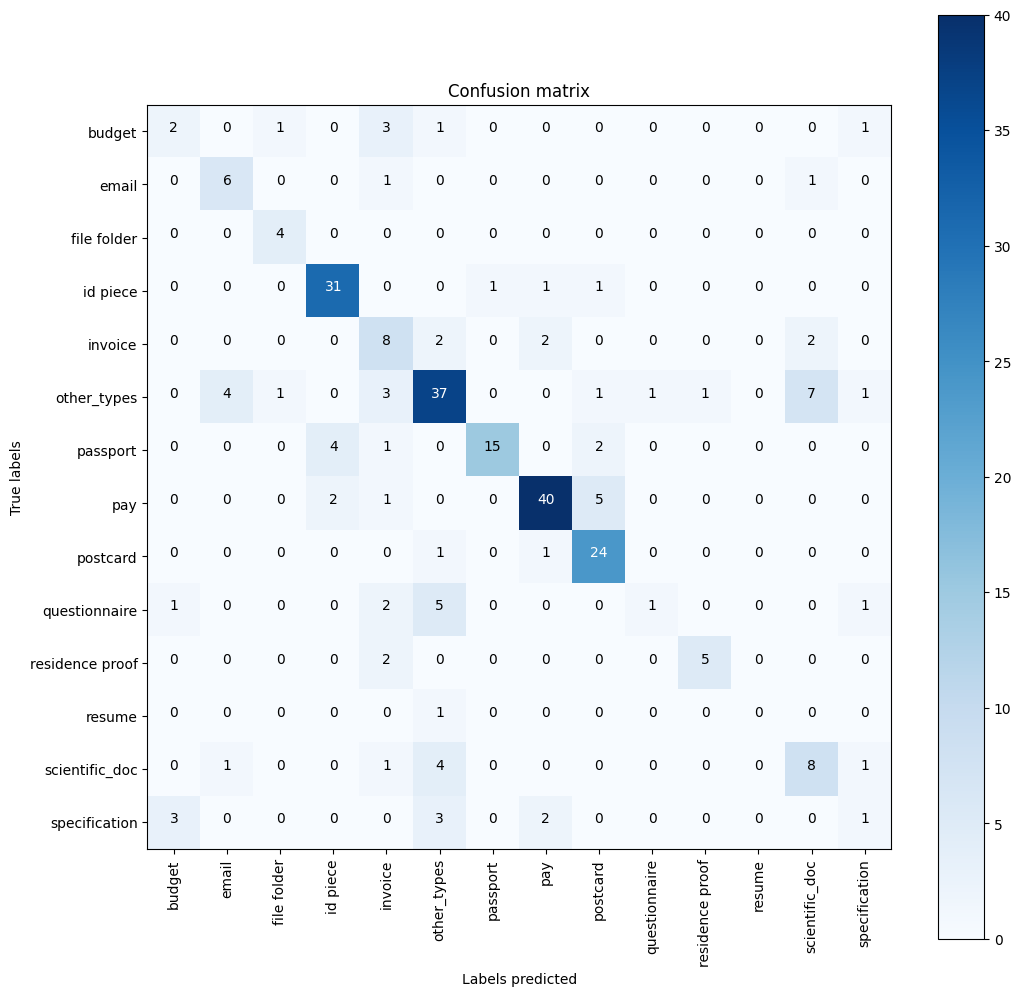

In [23]:
# Class predictions with type (passport, resume, etc...)
y_pred_type = pd.DataFrame(y_pred, index = y_test.index).replace(dico_type_inv)

confusion_matrix(y_test, y_pred_type)

> E. CLASSIFICATION REPORT

In [24]:
global_classification_report(y_test, y_pred_type, classifier = "VGG16", category = "ComputerVision target_min")

                 precision    recall  f1-score   support

         budget       0.33      0.25      0.29         8
          email       0.55      0.75      0.63         8
    file folder       0.67      1.00      0.80         4
       id piece       0.84      0.91      0.87        34
        invoice       0.36      0.57      0.44        14
    other_types       0.69      0.66      0.67        56
       passport       0.94      0.68      0.79        22
            pay       0.87      0.83      0.85        48
       postcard       0.73      0.92      0.81        26
  questionnaire       0.50      0.10      0.17        10
residence proof       0.83      0.71      0.77         7
         resume       0.00      0.00      0.00         1
 scientific_doc       0.44      0.53      0.48        15
  specification       0.20      0.11      0.14         9

       accuracy                           0.69       262
      macro avg       0.57      0.57      0.55       262
   weighted avg       0.70   

C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\User

## <font color = blue>V. WRONG PREDICTIONS</font>

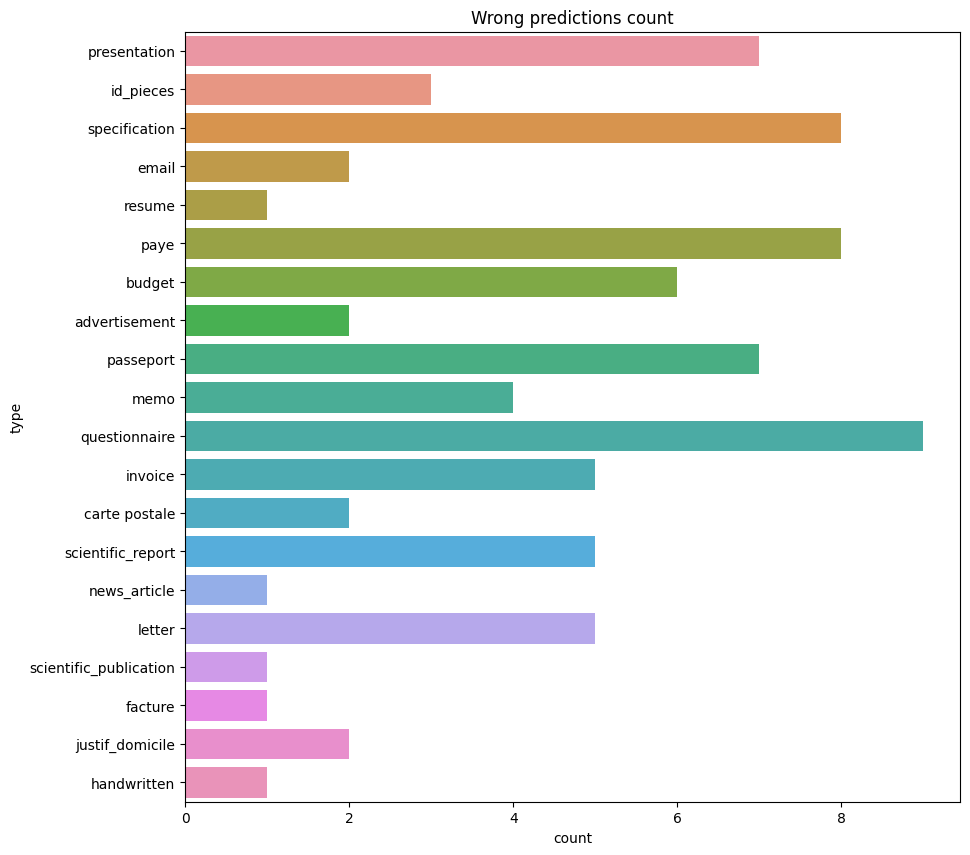

## Wrong predictions for questionnaire

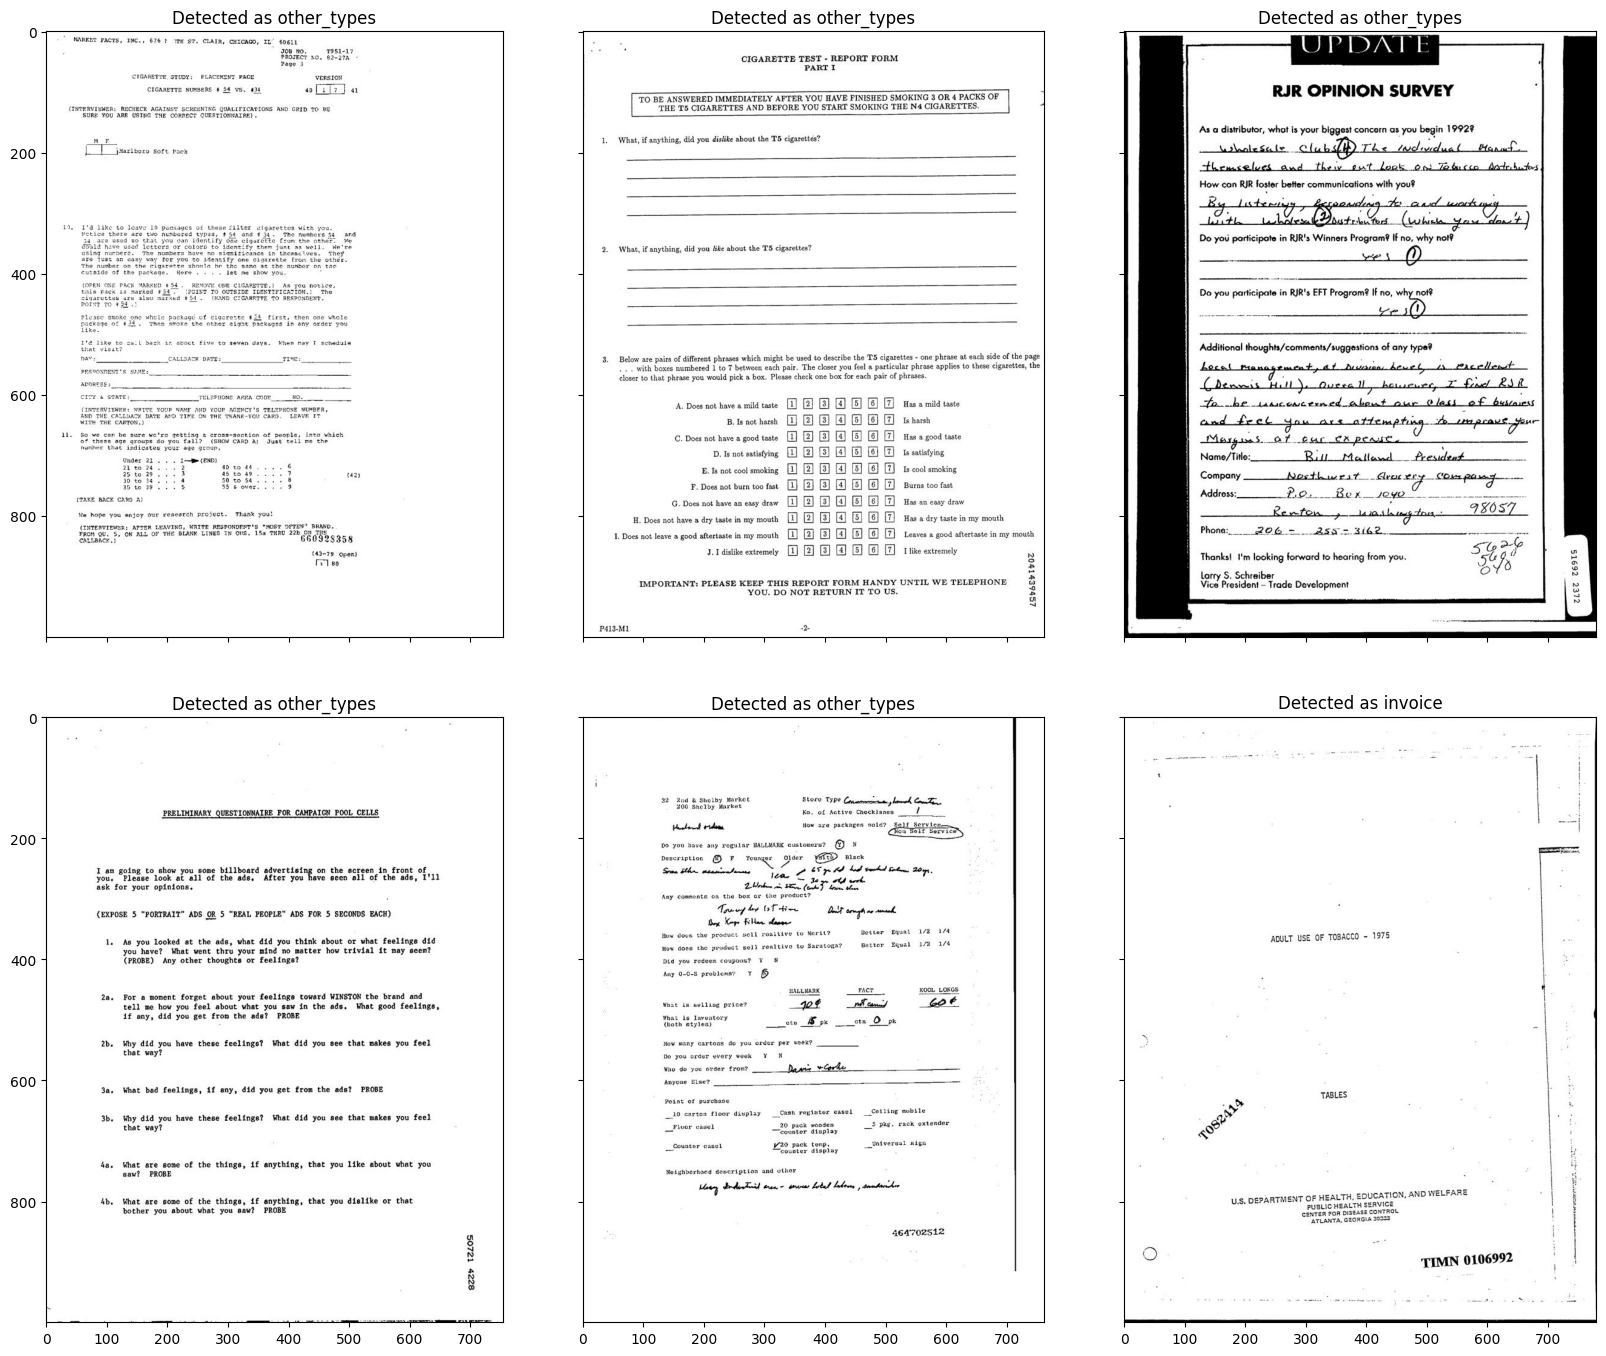

## Wrong predictions for paye

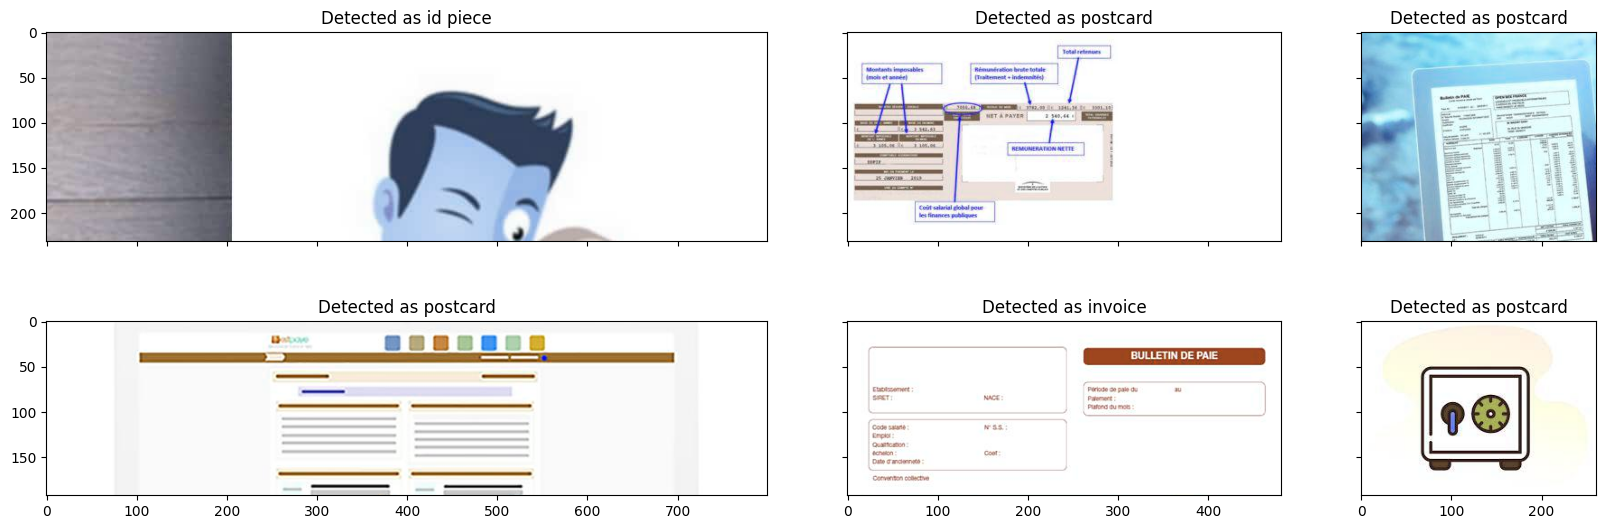

## Wrong predictions for specification

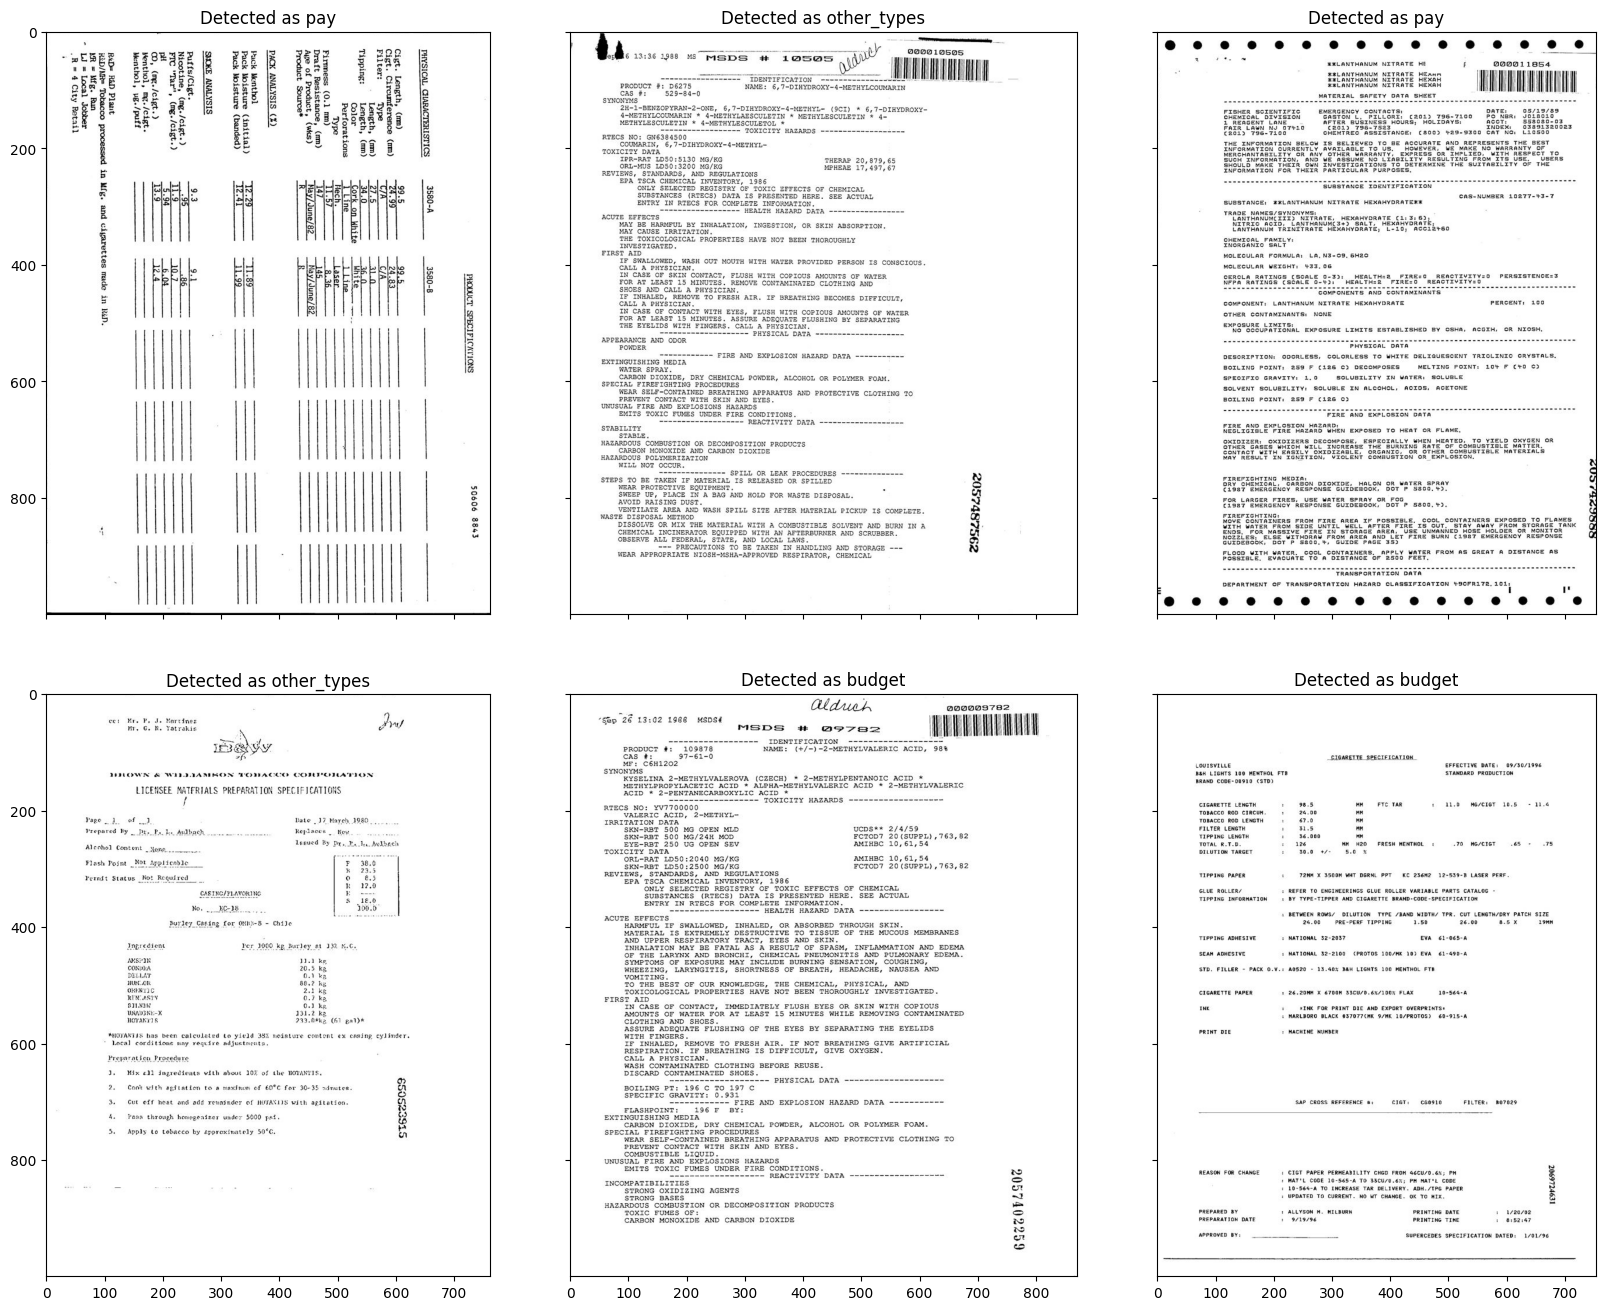

## Wrong predictions for passeport

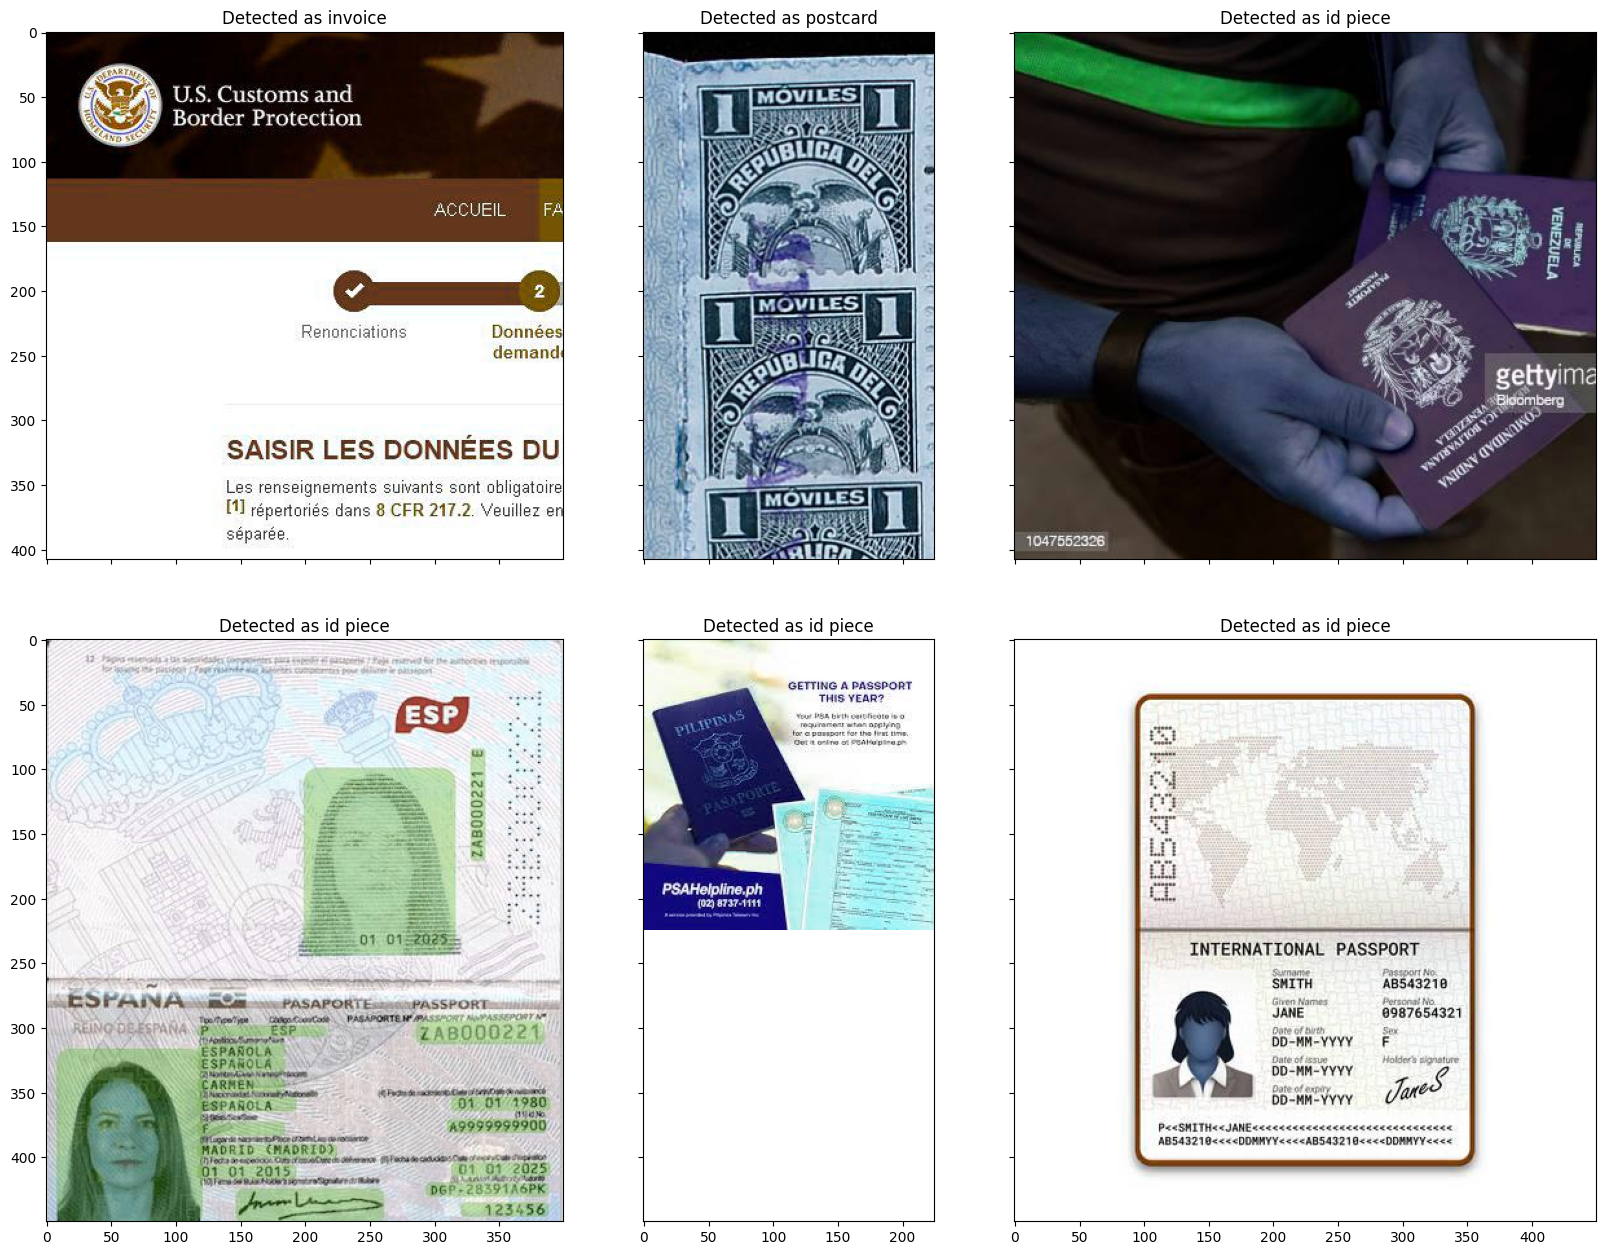

## Wrong predictions for presentation

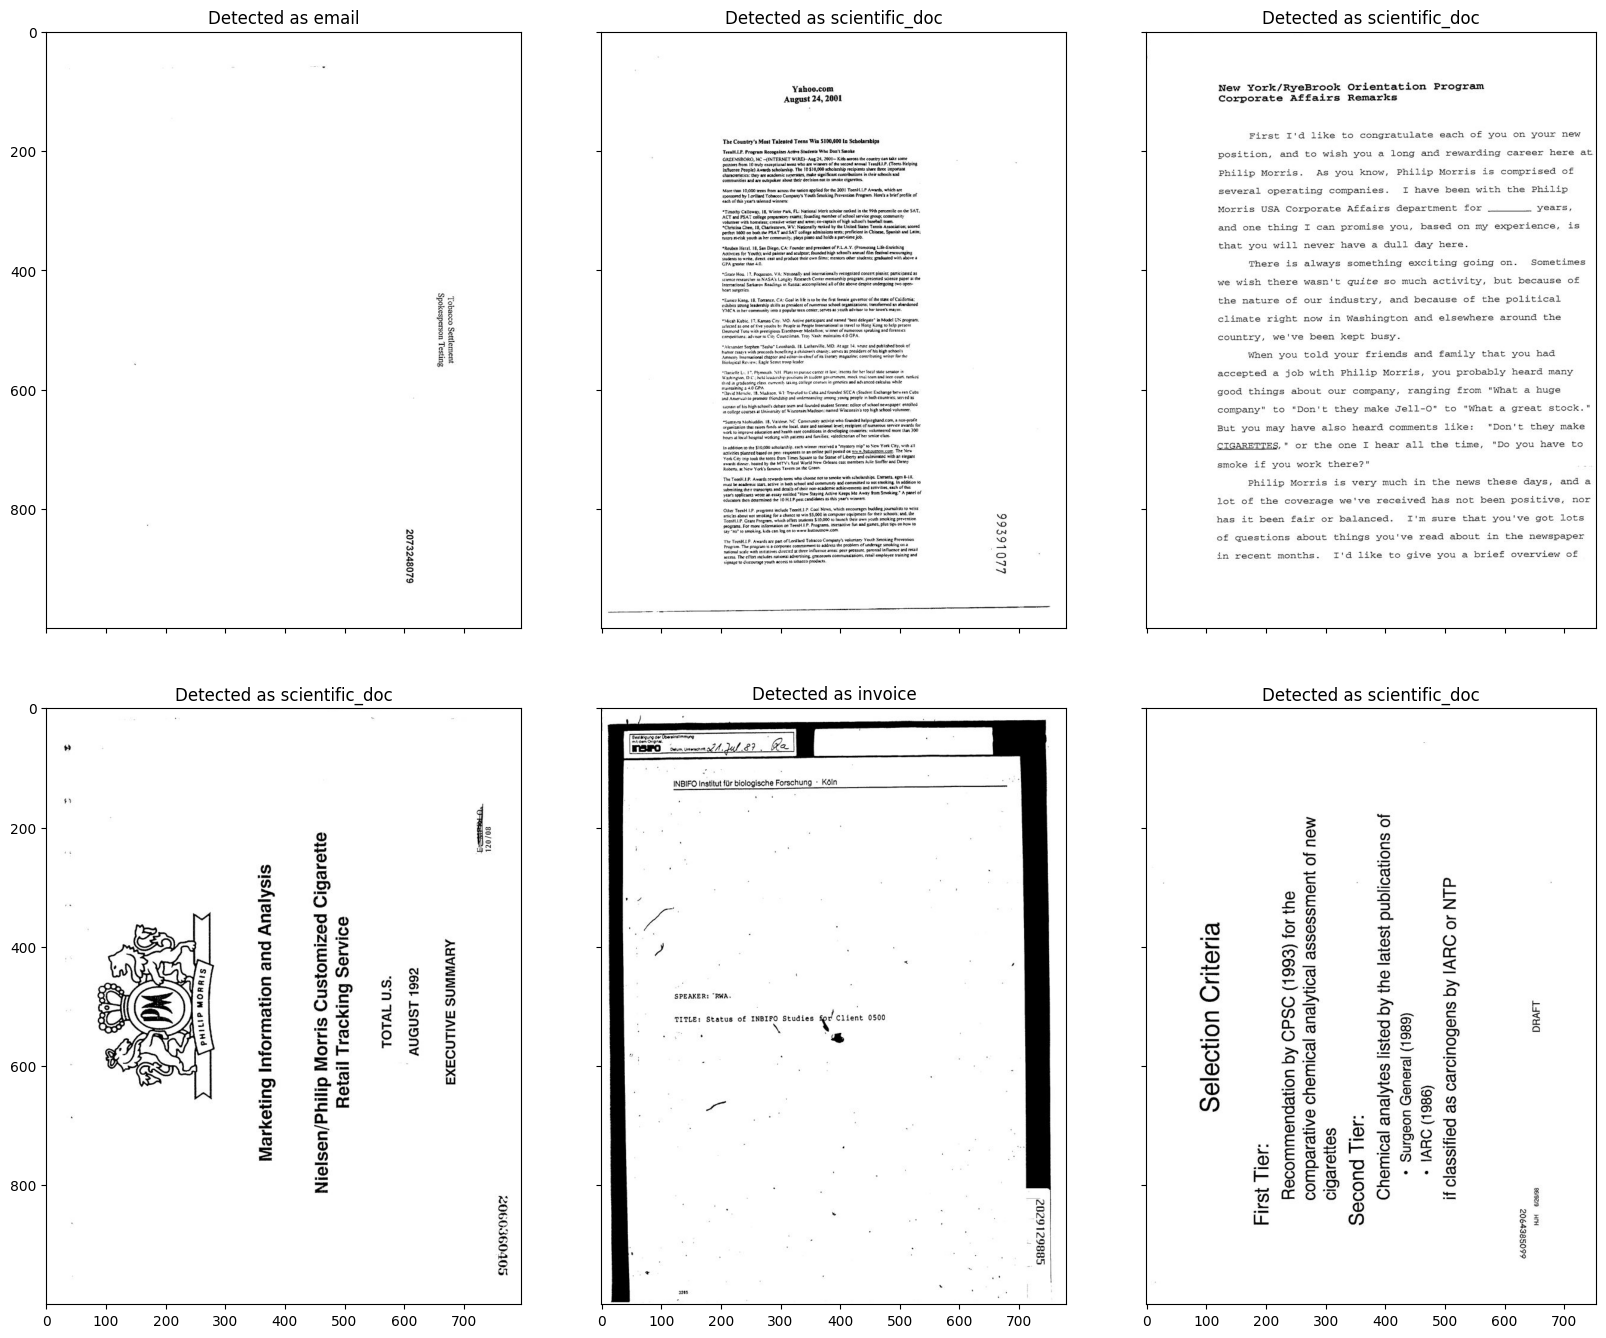

## Wrong predictions for budget

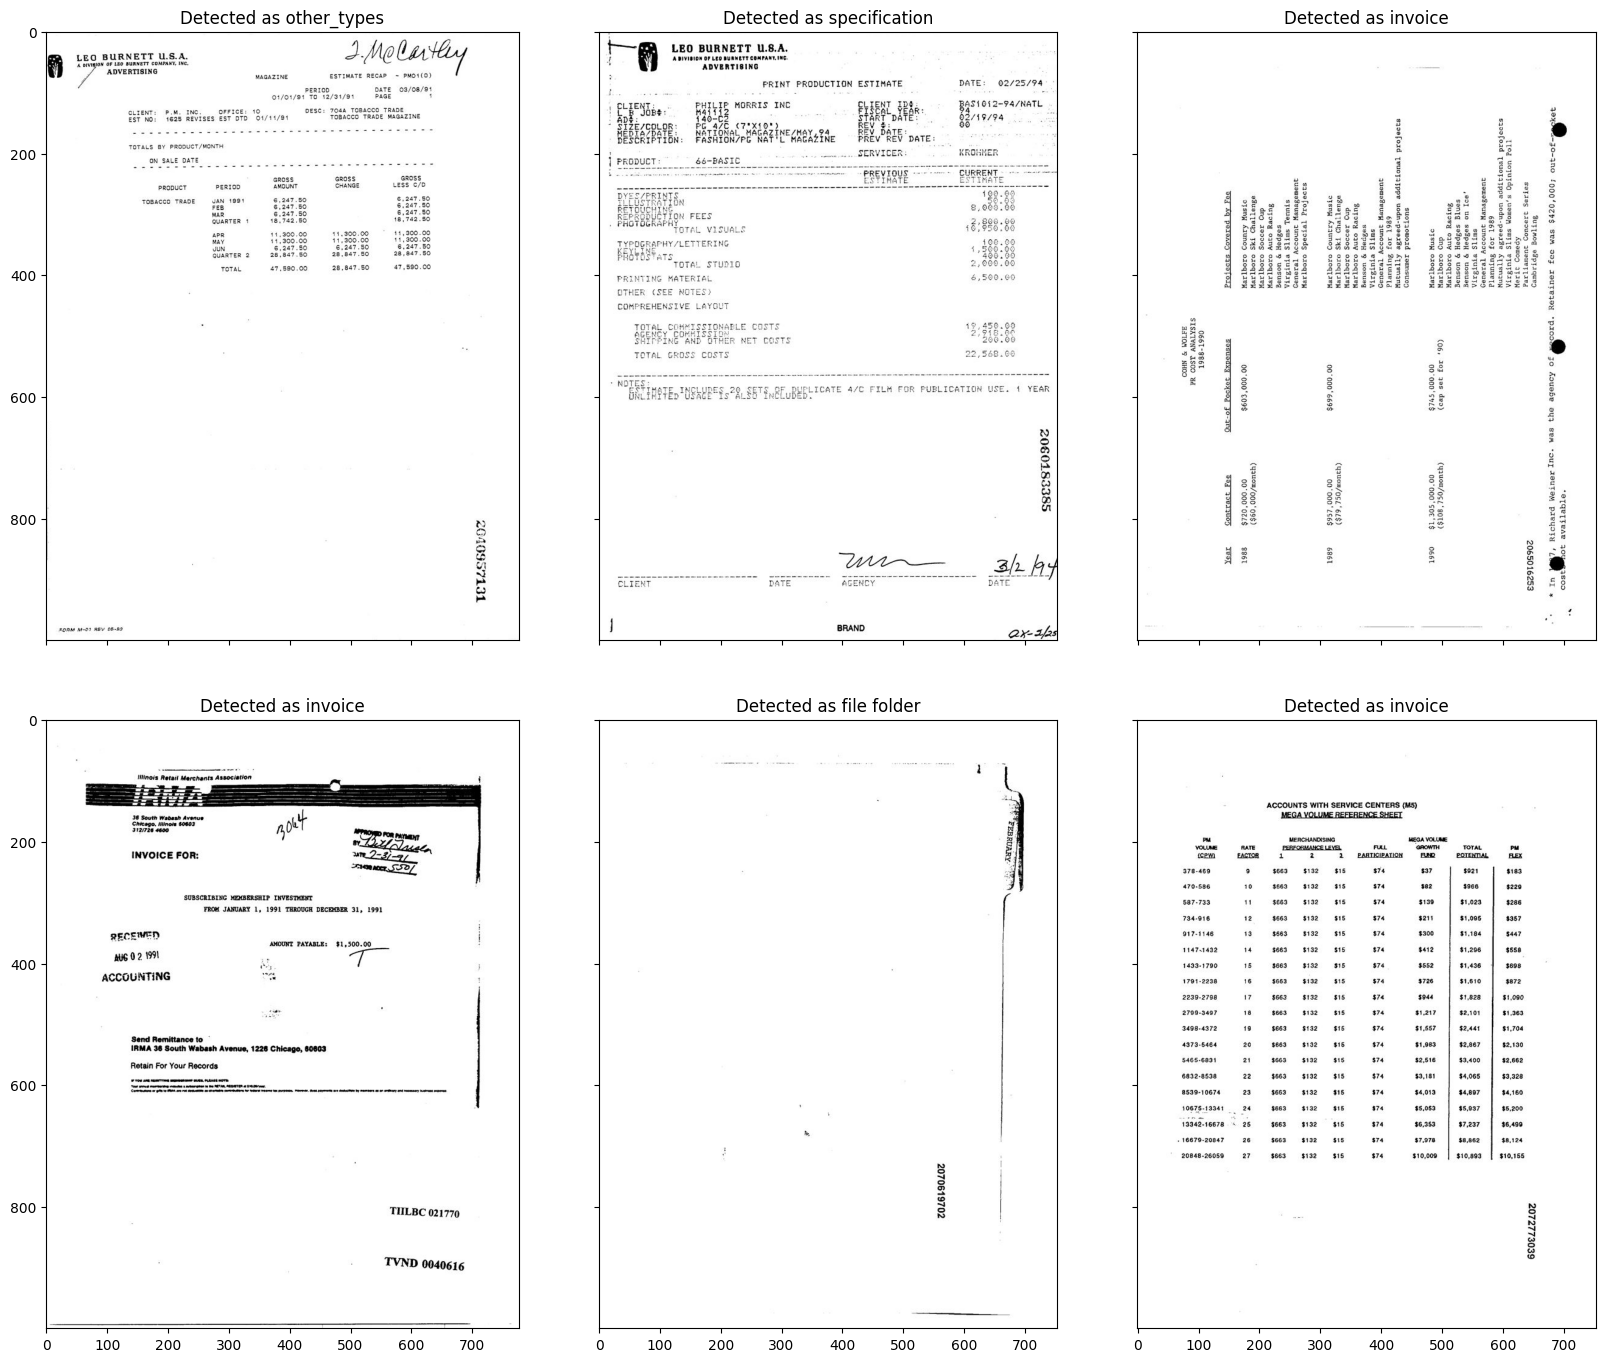

## Wrong predictions for invoice

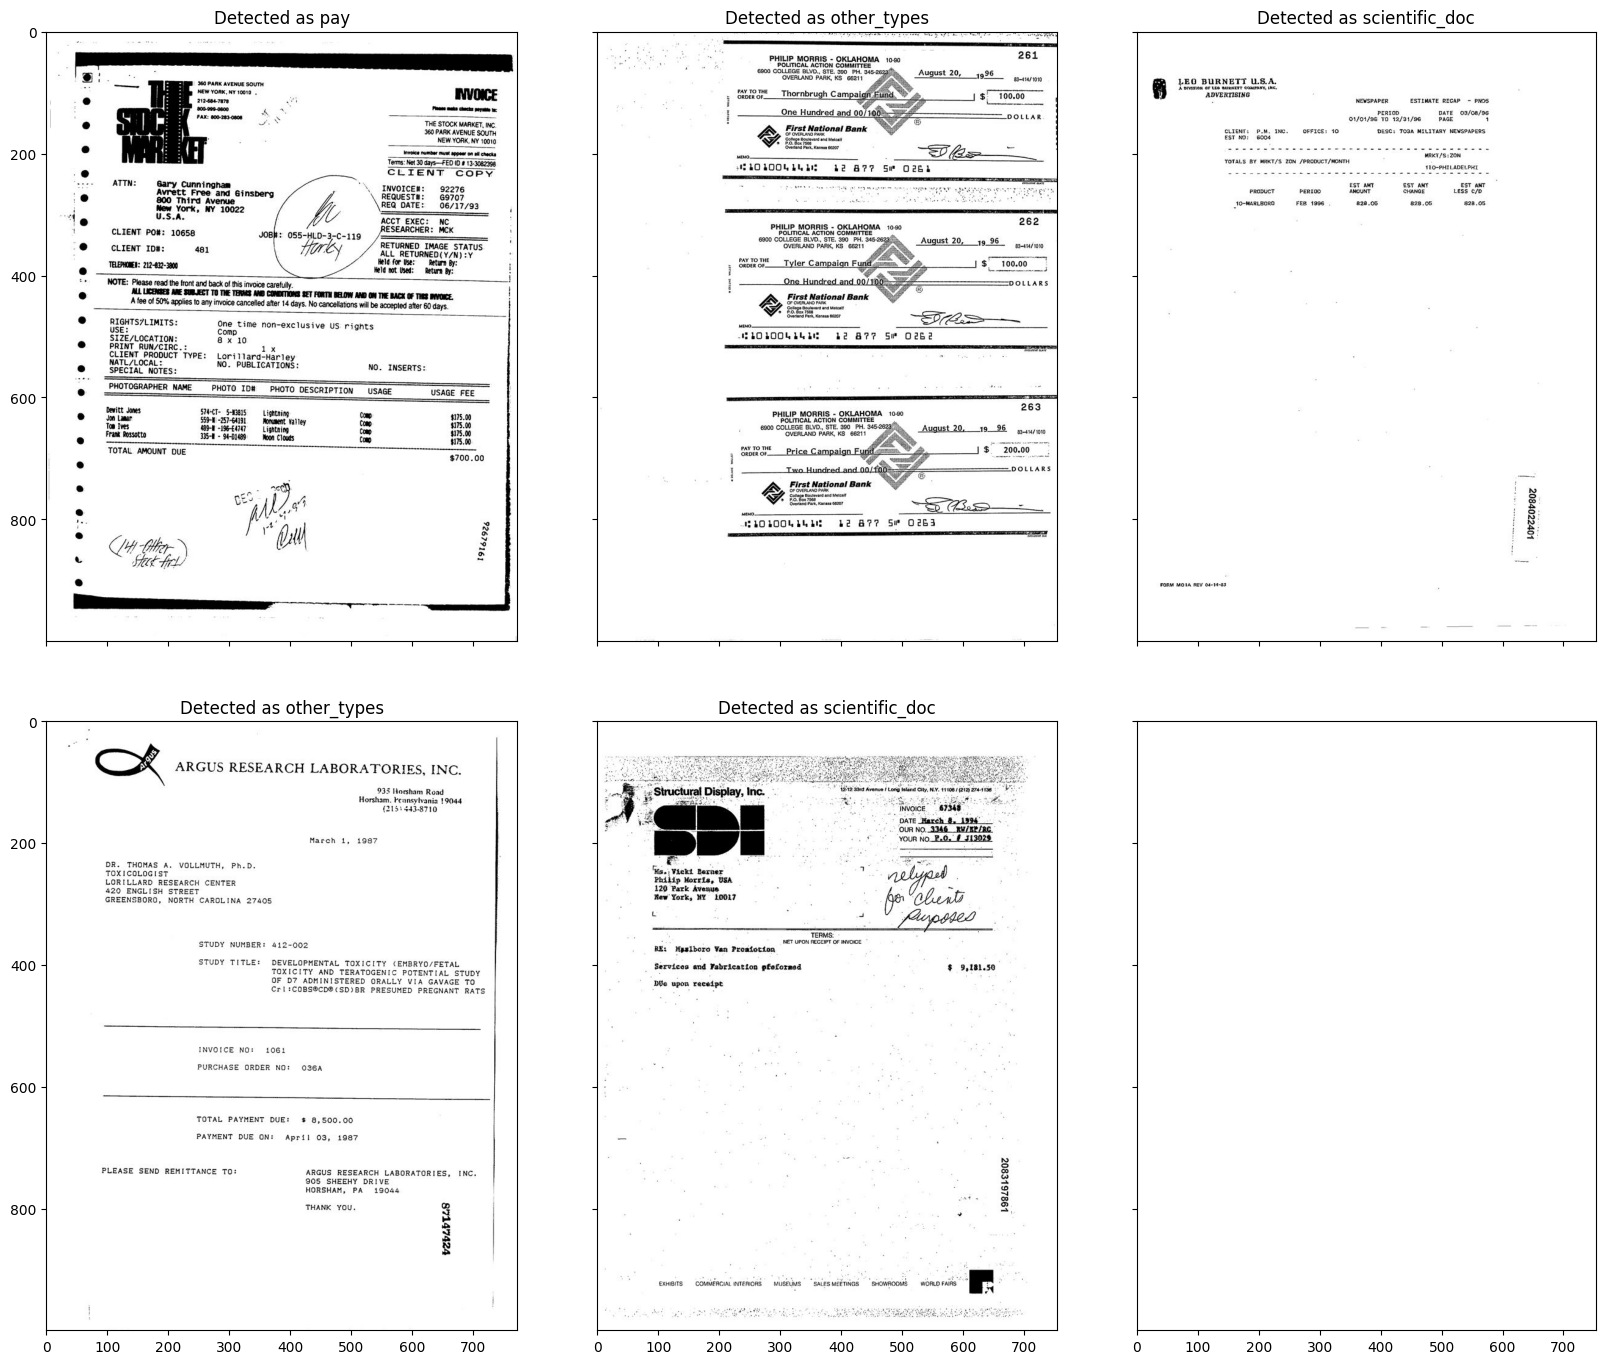

## Wrong predictions for scientific_report

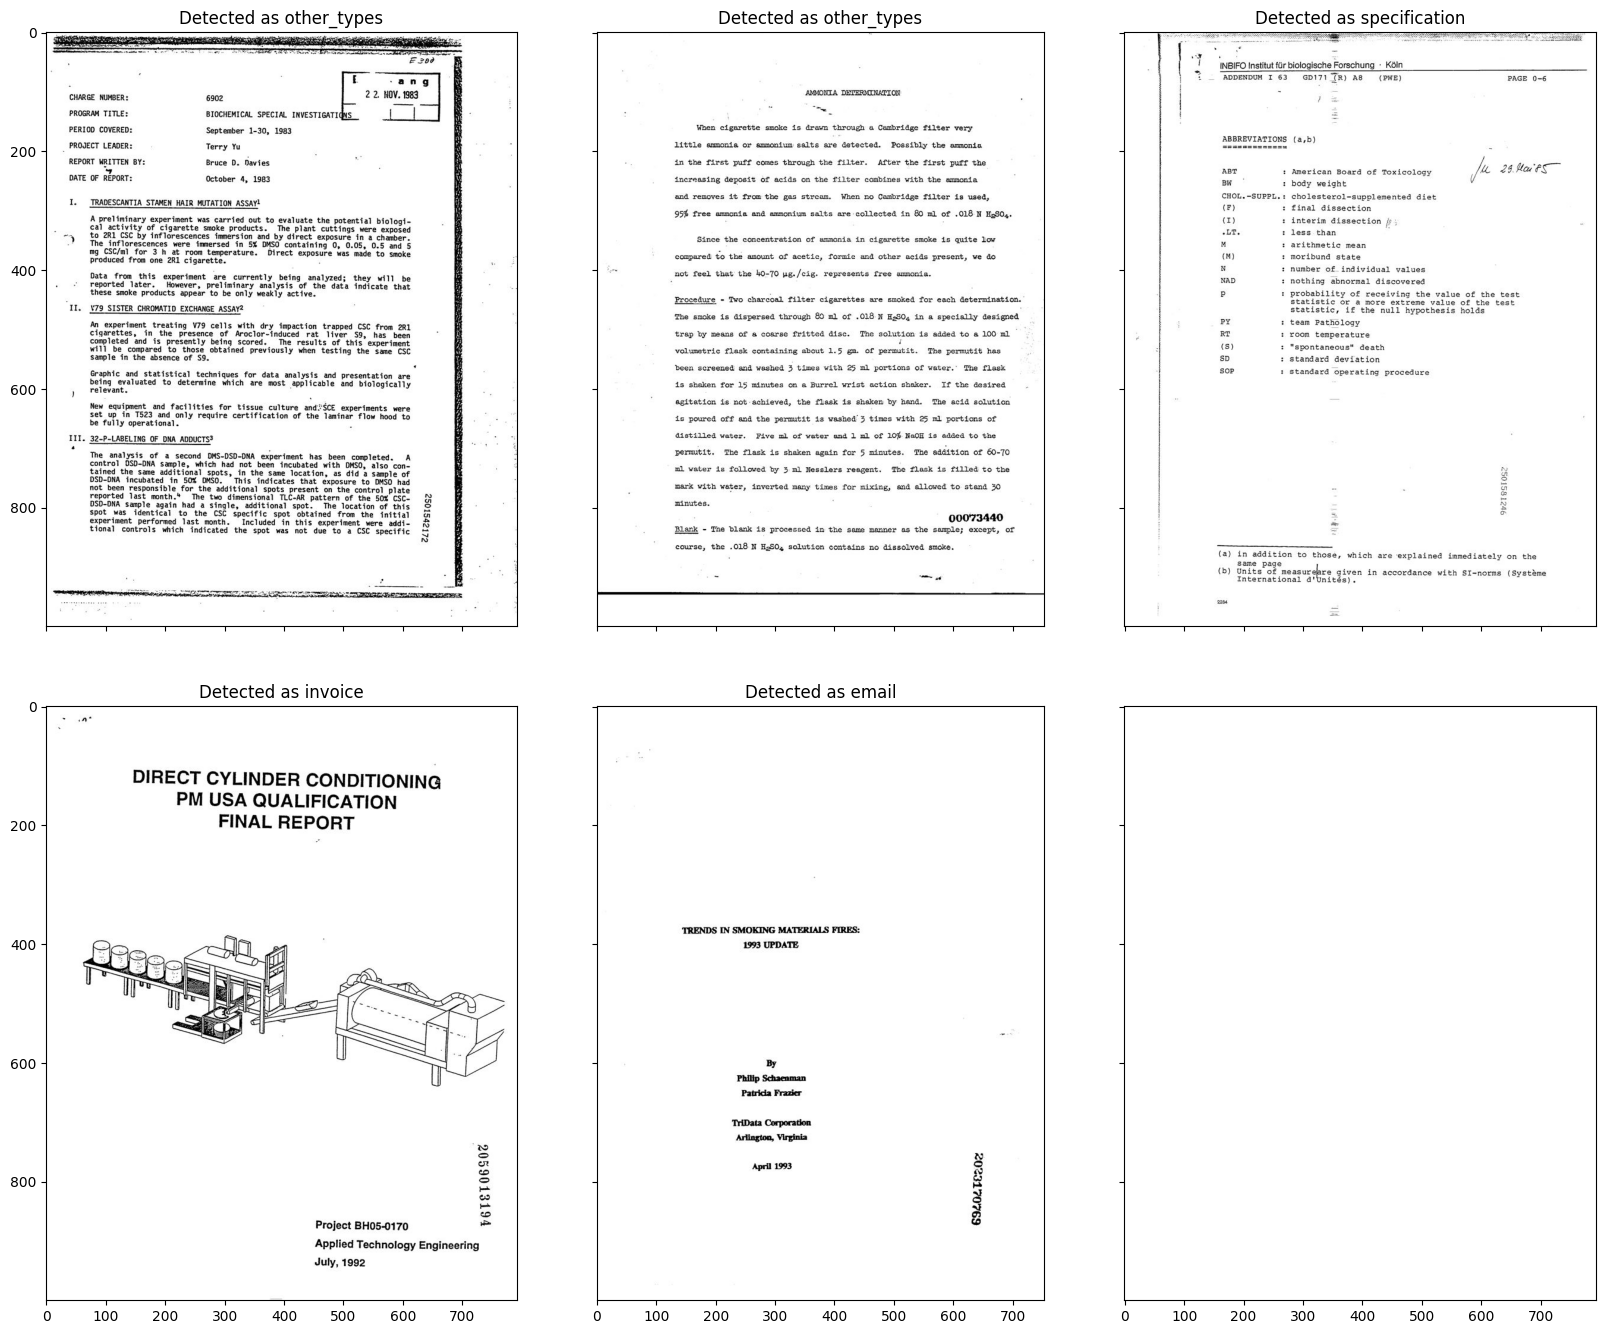

In [25]:
show_wrong_predictions(df, y_test, y_pred_type)